# **Underwater Object Classification using CNNs**

### **Importing Dataset and necessary packages**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf

import os

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

DATA_PATH = "/content/drive/MyDrive/SONAR/SeabedObjects-KLSG--II"

In [ ]:
train_data = datagen.flow_from_directory(
                DATA_PATH,
                target_size=(224, 224),
                class_mode="sparse",
                batch_size=32,
                shuffle=True,
                subset='training',
                seed=42)
test_data = datagen.flow_from_directory(
                DATA_PATH,
                target_size=(224, 224),
                class_mode="sparse",
                shuffle=False,
                batch_size=32,
                subset='validation',
                seed=42)

Found 906 images belonging to 3 classes.
Found 225 images belonging to 3 classes.


In [ ]:
class_names = np.sort(["Plane", "Sea Floor", "Ship"])
class_names

array(['Plane', 'Sea Floor', 'Ship'], dtype='<U9')

## **Plotting random images from the train dataset**

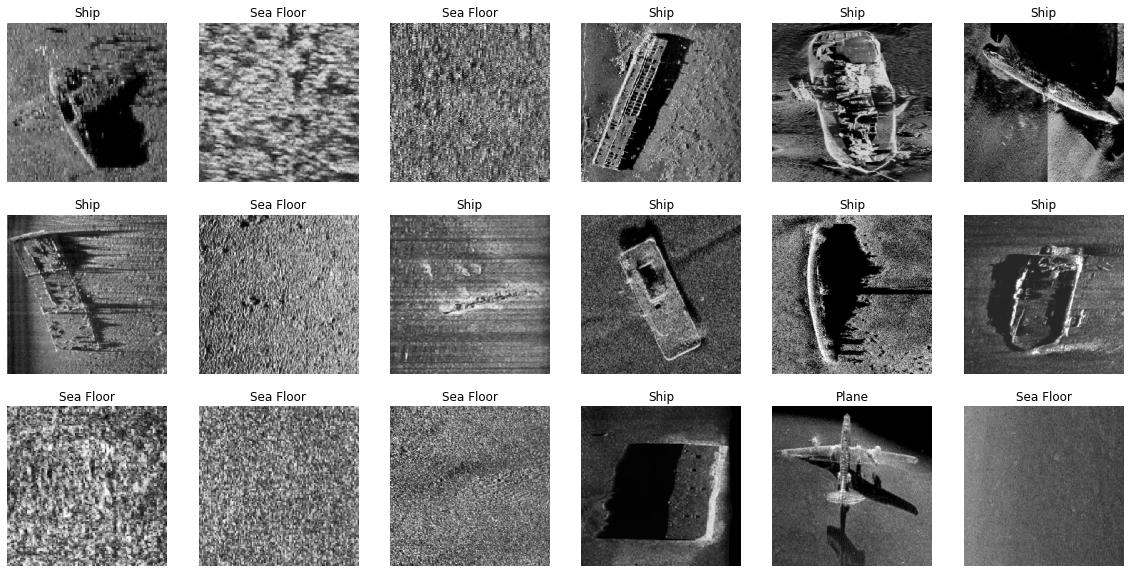

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
images, labels = next(train_data)
i=0
for image, label in zip(images, labels):
  ax = plt.subplot(3, 6, i + 1)
  plt.imshow(image.astype("uint8"))
  plt.title(class_names[int(label)])
  plt.axis("off")
  i+=1
  if i==18: break

## **Building the Model**

In [ ]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)

x = GlobalAveragePooling2D(name="GlobalAveragePooling2D")(x)

x = Dense(3, name='output_layer')(x)
outputs = Activation('softmax', name='softmax_activation')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePooling2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
 softmax_activation (Activat  (None, 3)                0         
 ion)                                                            
                                                              

#### **Setting up Callbacks**

In [ ]:
# EarlyStopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=3, verbose=1, monitor="val_accuracy")

# ReduceLROnPlateau Callback
lower_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,
                                                monitor='val_accuracy',
                                                min_lr=1e-7,
                                                patience=0,
                                                verbose=1)

#### **Training the Model**

In [ ]:
history = model.fit(train_data,
                    epochs=15,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[lower_lr, 
                               early_stopping_callback])

Epoch 1/15
29/29 [==============================] - 158s 5s/step - loss: 0.4067 - accuracy: 0.8742 - val_loss: 0.2345 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 2/15
29/29 [==============================] - 5s 164ms/step - loss: 0.1823 - accuracy: 0.9371 - val_loss: 0.1860 - val_accuracy: 0.9378 - lr: 0.0010
Epoch 3/15
29/29 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.9503
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
29/29 [==============================] - 5s 160ms/step - loss: 0.1379 - accuracy: 0.9503 - val_loss: 0.1604 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 4/15
29/29 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.9514
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
29/29 [==============================] - 5s 160ms/step - loss: 0.1310 - accuracy: 0.9514 - val_loss: 0.1580 - val_accuracy: 0.9333 - lr: 2.0000e-04
Epoch 5/15
29/29 [==============================] - ETA: 

### **Accuracy and other Evaluation Metrics**

In [ ]:
model.evaluate(test_data)

8/8 [==============================] - 1s 99ms/step - loss: 0.1860 - accuracy: 0.9378


[0.18600007891654968, 0.9377777576446533]

In [ ]:
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_true = test_data.labels

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.23      0.38        13
           1       0.93      1.00      0.96       115
           2       0.95      0.96      0.95        97

    accuracy                           0.94       225
   macro avg       0.96      0.73      0.76       225
weighted avg       0.94      0.94      0.92       225



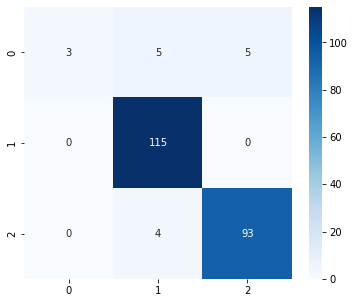

In [ ]:
cm = tf.math.confusion_matrix(y_true, y_pred)

import seaborn as sn
plt.figure(figsize = (6, 5));
sn.heatmap(cm, annot=True, 
           fmt='',
           cmap='Blues');

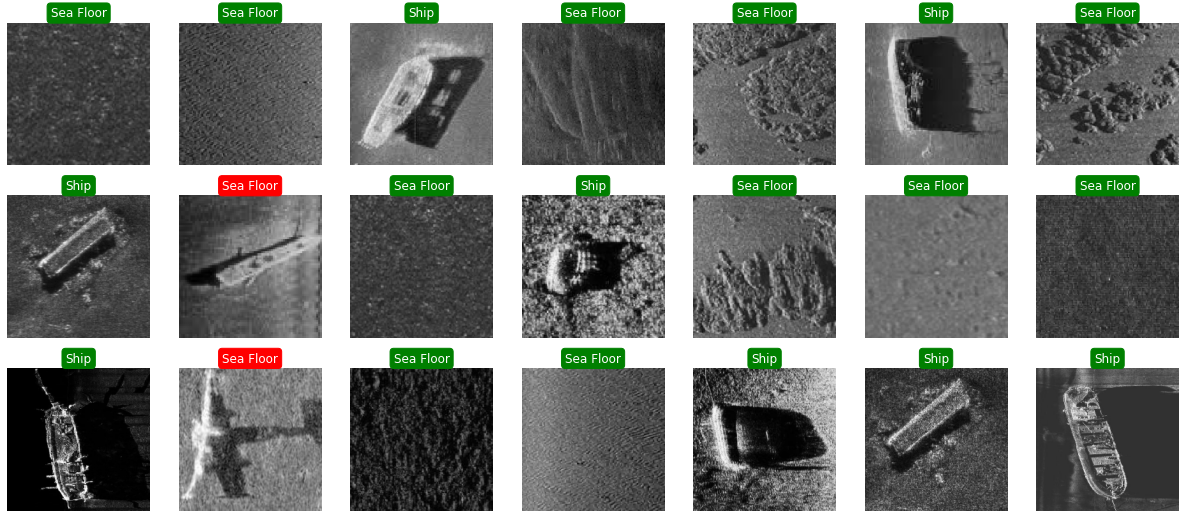

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(21, 9))

shuffle_test_data = test_data
shuffle_test_data.shuffle = True
images, labels = next(shuffle_test_data)

i=0

for image, label in zip(images, labels):
  ax = plt.subplot(3, 7, i + 1)
  plt.imshow(image.astype("uint8"))

  x=label
  pred_prob = model.predict(tf.expand_dims(image, axis=0))
  pred = class_names[np.argmax(pred_prob, axis=1)]

  if pred==class_names[int(x)]: 
    plt.title(f"{pred[0]}", color='white', 
              bbox=dict(boxstyle="round", 
                        color='green'))
  else: 
    plt.title(f"{pred[0]}", color='white', 
              bbox=dict(boxstyle="round", 
                        color='red'))
  plt.axis("off")
  i+=1
  if i==21: break